In [ ]:
import numpy as np
import pandas as pd

In [2]:
#读取训练数据
train_data = pd.read_csv("kddcup_train_data", header=None)

In [3]:
#读取测试数据
test_data = pd.read_csv("kddcup_test_data", header=None)

In [7]:
#定义数据每一列的列名
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
             "urgent","hot","num_failed_logins","logged_in","num_compromised",
             "root_shell","su_attempted","num_root","num_file_creations",
             "num_shells","num_access_files","num_outbound_cmds",
             "is_hot_login","is_guest_login","count","srv_count","serror_rate",
             "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
             "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
             "dst_host_rerror_rate","dst_host_srv_rerror_rate","target"]

In [8]:
#添加列名
train_data.columns = col_names
test_data.columns = col_names

In [9]:
#把训练数据和测试数据拆分为: 训练数据特征（x_train）训练数据标签（y_train）测试数据特征（x_test）测试数据标签（y_test）
x_train = train_data.iloc[:,:train_data.shape[1]-1]
y_train = train_data.iloc[:,train_data.shape[1]-1:]

x_test = test_data.iloc[:,:test_data.shape[1]-1]
y_test = test_data.iloc[:,test_data.shape[1]-1:]

In [10]:
#将三个特征为单词的列做 "one hot" 转换
x_train_dummy = pd.get_dummies(x_train, columns=["protocol_type","service","flag"])
x_test_dummy = pd.get_dummies(x_test, columns=["protocol_type","service","flag"])

In [11]:
# 检查训练和测试数据集的列数是否一致
missing_cols = set(x_train_dummy.columns) - set(x_test_dummy.columns)
for c in missing_cols:
    print(c)
    x_test_dummy[c] = 0
    
# 确保列的顺序是一致的
x_test_dummy = x_test_dummy[x_train_dummy.columns]

from IPython.display import display
display(x_test_dummy.head(1))

service_red_i
service_urh_i


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,105,146,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
# 为了SVM可以收敛，将特征值修改到-1到1之间
from sklearn.preprocessing import MinMaxScaler
x_train_scale = x_train_dummy
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train_scale)
x_train_scale = scaling.transform(x_train_scale)
                                             
x_test_scale = x_test_dummy
x_test_scale = scaling.transform(x_test_scale)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
#训练并生成模型

import time
from sklearn import svm
rseed = 93
time_start = time.time()
model_svm = svm.SVC(kernel='linear', C=1, verbose=True, random_state=rseed, decision_function_shape="ovo").fit(x_train_scale, y_train.values.ravel())
print("training completed, using time %5.2f seconds" % (time.time()-time_start))

[LibSVM]model completed, using time 276.65 seconds


In [14]:
#保存模型到本地

from sklearn.externals import joblib
model_name = "model_svm.sav"
joblib.dump(model_svm,model_name)

['model_svm.sav']

In [15]:
# 计算预测的准确率，分别用训练数据集和测试数据集
print("accuracy based on training: %5.4f" % model_svm.score(x_train_scale, y_train))  

print("accuracy based on testing: %5.4f" % model_svm.score(x_test_scale, y_test)) 

accuracy based on training: 0.9987
accuracy based on testing: 0.9240


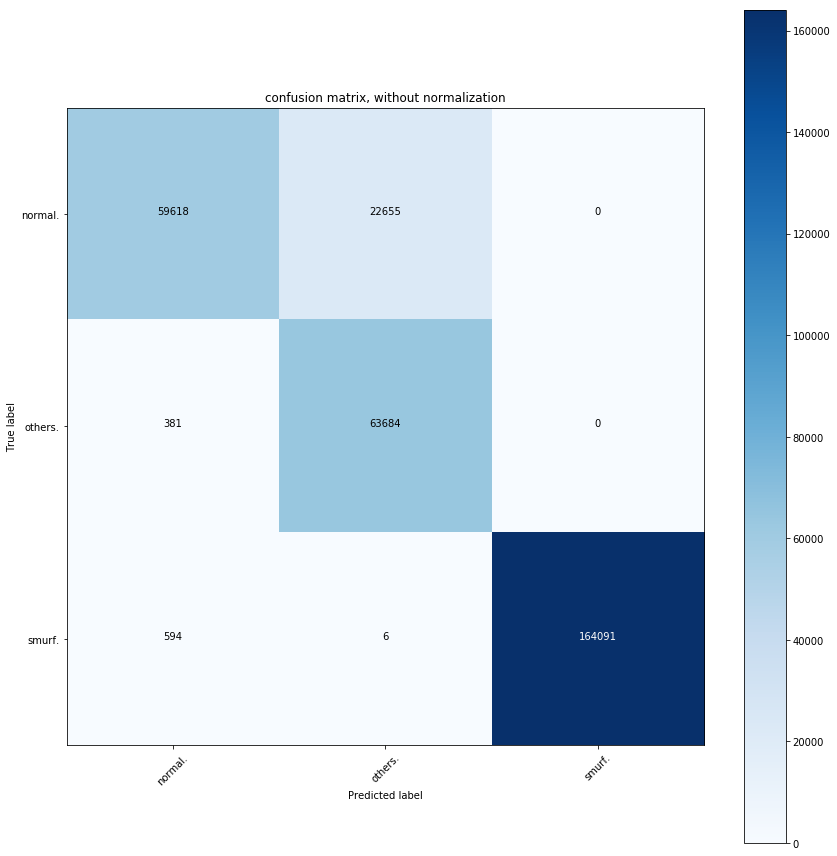

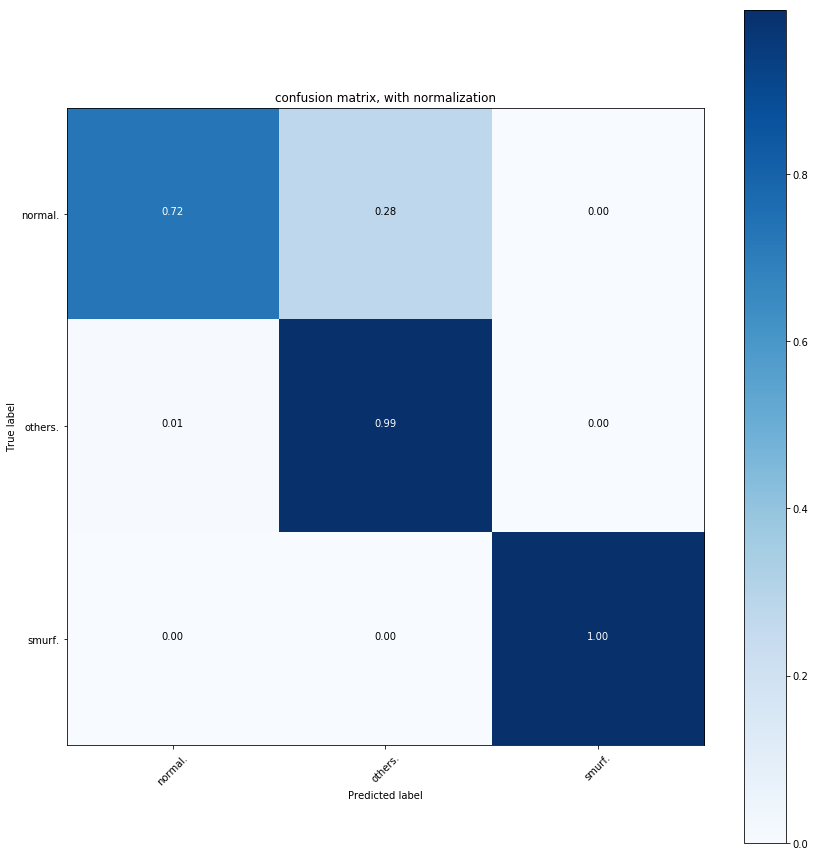

In [18]:
# 计算 Confusion Matrix 并生成图形

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import itertools

cnf_model_svm = confusion_matrix(model_svm.predict(x_test_scale),y_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print("")
        #print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Value')
    plt.xlabel('Predicted Value')
    

import numpy as np
np.set_printoptions(precision=2)

width = 6
height = 6
plt.figure(figsize=(width, height))
plot_confusion_matrix(cnf_model_svm, classes=model_svm.classes_, title="Confusion Matrix without Normalization")

plt.figure(figsize=(width, height))
plot_confusion_matrix(cnf_model_svm, classes=model_svm.classes_, normalize=True, title="Confusion Matrix with Normalization")

plt.show()